vscode 프로젝트 루트 경로 문제로 아래 셀은 vscode에서만 실행

In [1]:
cd ..

c:\Users\jeong\Desktop\대학원 수업\handcrafted-object-detection


In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8,6)

# 이진화

hsv에서 v채널로 이진화

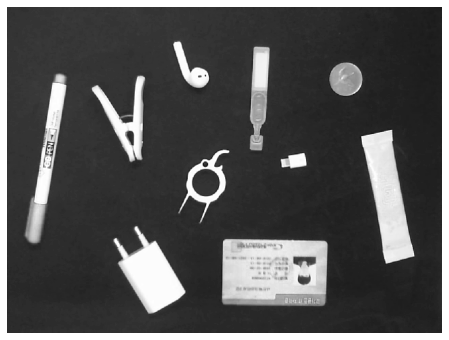

In [3]:
IMG_PATH = "data/sample.png"
img_color = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)
img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
img = img[...,2]
plt.axis('off'); plt.imshow(img, cmap='gray'); plt.show()

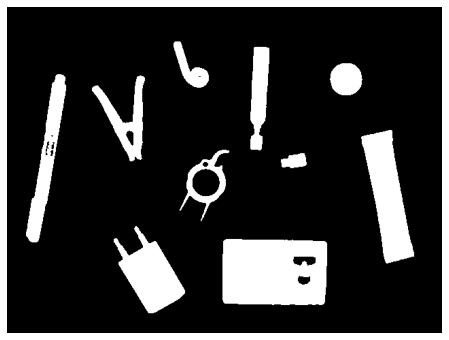

In [4]:
img_br = cv2.GaussianBlur(img, (5, 5), 0)
_, img_th = cv2.threshold(img_br, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.axis('off')
plt.imshow(img_th, cmap='gray')
plt.show()

# 모폴로지 적용

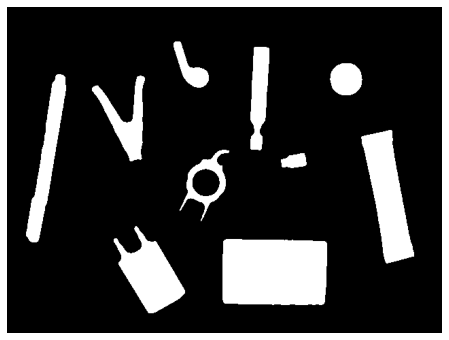

In [5]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
img_mp = cv2.morphologyEx(img_th, cv2.MORPH_CLOSE, kernel)
plt.axis('off')
plt.imshow(img_mp, cmap='gray')
plt.show()

# 라벨 확인

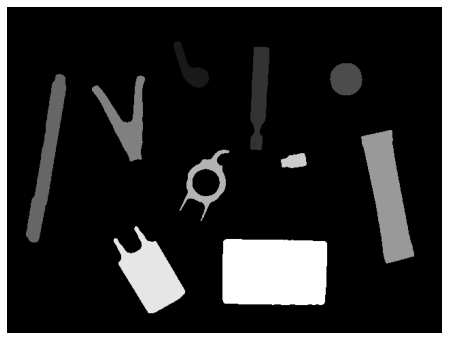

labels: [ 0  1  2  3  4  5  6  7  8  9 10]
labels_cnt: 11


In [6]:
labels_cnt, labels, stats, centriods = cv2.connectedComponentsWithStats(img_mp)

plt.axis('off')
plt.imshow(labels, cmap='gray')
plt.show()
print(f"labels: {np.unique(labels)}\nlabels_cnt: {labels_cnt}")

# 특성 확인

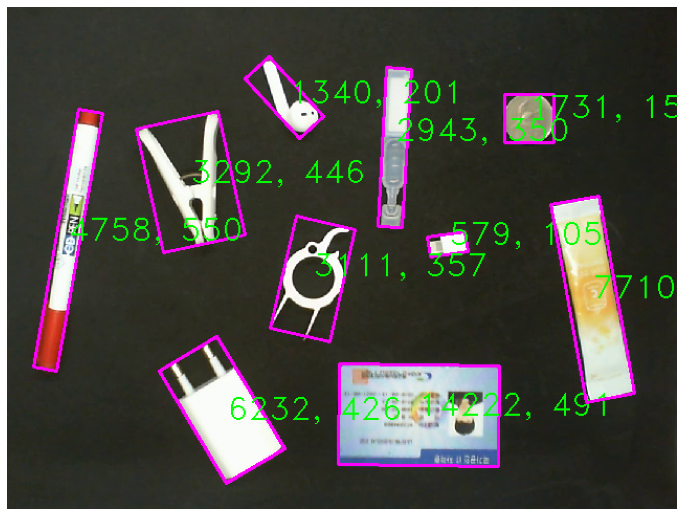

In [11]:
plt.rcParams['figure.figsize'] = (12,12)

contours, _ = cv2.findContours(img_mp, 0, cv2.CHAIN_APPROX_NONE)
img_out = img_color.copy()

areas = []
perimeters = []
formfactors = []
for idx, contour in enumerate(contours):
    # 컨투어와 모멘트로 bbox, centroid, area, perimeter, formfactor 계산
    M = cv2.moments(contour)
    center = (int(M["m10"] // M["m00"]), int(M["m01"] // M["m00"]))
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    formfactor = 0
    if perimeter:
        formfactor = (4 * np.pi * area) / (perimeter ** 2)
    
    text = f"{int(area)}, {int(perimeter)}"

    cv2.drawContours(img_out, [np.int0(box)], 0, (255, 0, 255), 2)
    cv2.putText(img_out, text, center, 2, 1, (0, 255, 0))

    areas.append(area)
    perimeters.append(perimeter)
    formfactors.append(formfactor)
plt.axis('off')
plt.imshow(img_out)
plt.show()

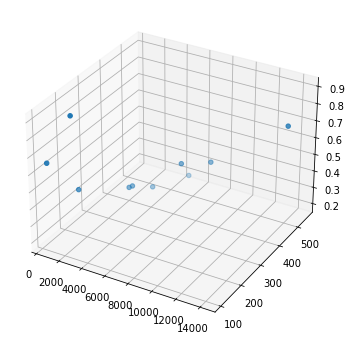

In [14]:
plt.rcParams['figure.figsize'] = (8,6)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(areas, perimeters, formfactors)
plt.show()

max dist: 13643.00000024655


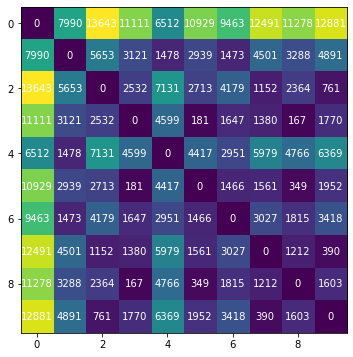

In [17]:
cnt = len(areas)
map = np.zeros((cnt, cnt))
for i in range(cnt):
    for j in range(cnt):
        map[i, j] += ((areas[i] - areas[j]) ** 2) 
        map[i, j] += ((formfactors[i] - formfactors[j]) ** 2) 
        map[i, j] = np.sqrt(map[i, j])

fig, ax = plt.subplots()
im = ax.imshow(map)
for i in range(cnt):
    for j in range(cnt):
        text = ax.text(j, i, int(map[i, j]),
                       ha="center", va="center", color="w")
print(f"max dist: {map.max()}")

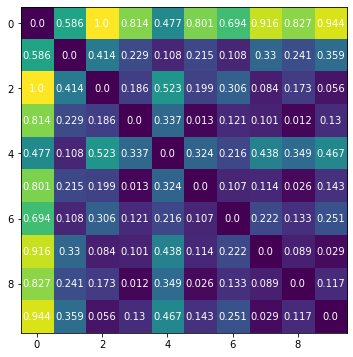

In [20]:
max = map.max()
for i in range(cnt):
    for j in range(cnt):
        map[i, j] = map[i, j] / max

fig, ax = plt.subplots()
im = ax.imshow(map)
for i in range(cnt):
    for j in range(cnt):
        text = ax.text(j, i, round(map[i, j], 3),
                       ha="center", va="center", color="w")